In [27]:
import pandas as pd
import numpy as np
from time import perf_counter 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
train = pd.read_csv('dialect_identification/data/all/train_prepro.csv')
test = pd.read_csv('dialect_identification/data/all/test_prepro.csv')

train.columns = ['text', 'variety', 'group']
test.columns = ['text', 'variety', 'group']
train = train[train.group == 'bks']
test = test[test.group == 'bks']
train = train.drop(columns=['group'])
test = test.drop(columns=['group'])

print(train.variety.value_counts())
print(test.variety.value_counts())
sets = [train, test]

l_enc = LabelEncoder()

for set in sets:
    set['variety_encoded'] = l_enc.fit_transform(set['variety'])
train.variety_encoded.value_counts()

variety
hr    18754
sr    18723
bs    18512
Name: count, dtype: int64
variety
sr    1984
bs    1970
hr    1962
Name: count, dtype: int64


variety_encoded
1    18754
2    18723
0    18512
Name: count, dtype: int64

In [29]:
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train.variety_encoded)

train_text = tf.constant(train['text'].values)
train_label = tf.constant(train['variety_encoded'].values, dtype=tf.int64)

val_text = tf.constant(val['text'].values)
val_label = tf.constant(val['variety_encoded'].values, dtype=tf.int64)

test_text = tf.constant(test['text'].values)
test_label = tf.constant(test['variety_encoded'].values, dtype=tf.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_label))

In [30]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [31]:
vocab_size = len(np.unique(np.hstack(train['text'].values)))
vocab_size


44759

In [32]:
VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

## Model: biLSTM

In [33]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [34]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          3200000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3274499 (12.49 MB)
Trainable params: 327

## Training the model

In [35]:
VAL_STEPS = test.shape[0] // BATCH_SIZE
EPOCHS = 3

In [36]:
history = model.fit(train_dataset, epochs=EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=VAL_STEPS)

Epoch 1/3
700/700 [==============================] - 63s 87ms/step - loss: 0.9067 - accuracy: 0.5558 - val_loss: 0.6785 - val_accuracy: 0.7030
Epoch 2/3
700/700 [==============================] - 64s 91ms/step - loss: 0.5241 - accuracy: 0.7756 - val_loss: 0.5864 - val_accuracy: 0.7427
Epoch 3/3
700/700 [==============================] - 59s 84ms/step - loss: 0.3465 - accuracy: 0.8655 - val_loss: 0.6450 - val_accuracy: 0.7442


In [37]:
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to numpy array
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)



93/93 [==============================] - 3s 17ms/step


In [38]:
test_loss, test_acc = model.evaluate(test_dataset)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test F1 Score:', f1)

93/93 [==============================] - 2s 20ms/step - loss: 0.6037 - accuracy: 0.7593
Test Loss: 0.60366290807724
Test Accuracy: 0.7592968344688416
Test F1 Score: 0.7631827450520283


In [39]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.9347566977143288)

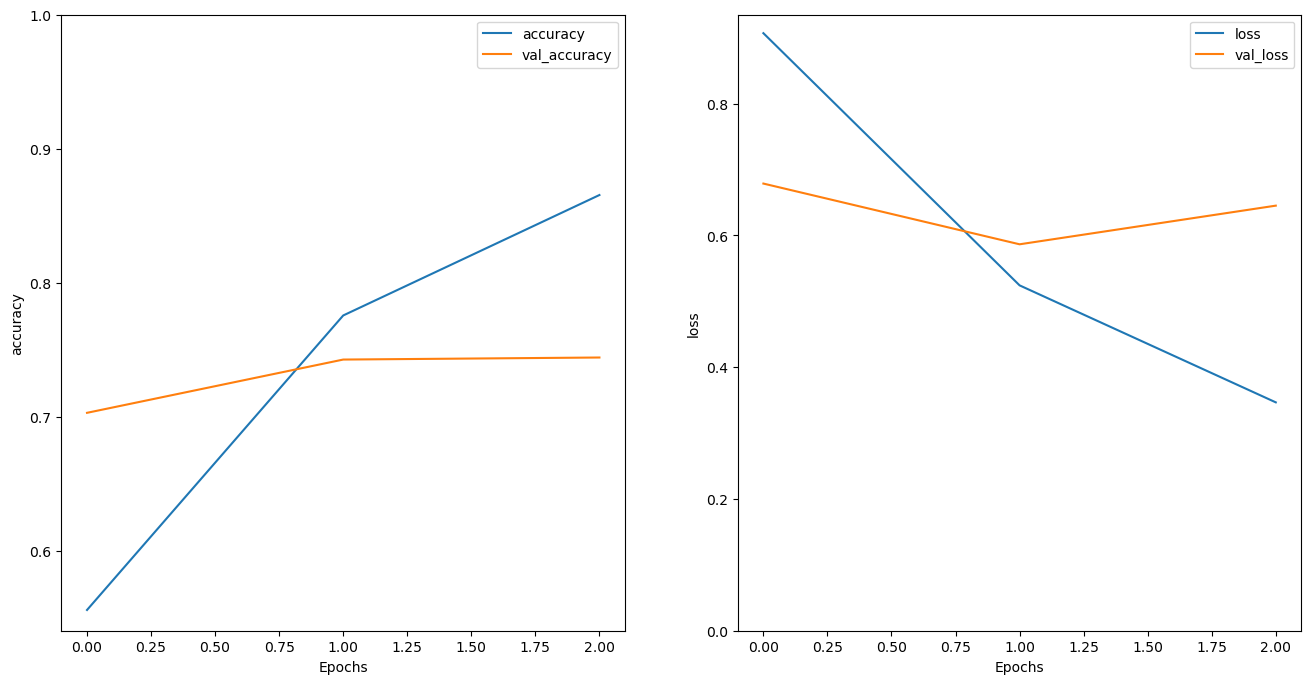

In [40]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)